In [5]:
#import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [9]:
#import data
data = pd.read_csv('D:\\My DS Projects\\Natural-language-processing-using-LSTM\\Tweets.csv\\Tweets.csv')
data.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Overview of Data

In [10]:
data.shape

(14640, 15)

In [11]:
data.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [12]:
data = data[['text','airline_sentiment']]
data.head(10)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
7,@VirginAmerica Really missed a prime opportuni...,neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an ...",positive


Data Cleaning

In [13]:
# considering only text and sentiment
data['text'] = data['text'].map(lambda x: x.lower())
data['text'] = data['text'].map(lambda x: re.sub('[^a-z0-9\s]','', x))

# Remove'@' from the 'text' column
data['text'] = data['text'].str.replace(r'@\S+', '', regex=True)

In [14]:
data.head(10)

,text,airline_sentiment
0,virginamerica what dhepburn said,neutral
1,virginamerica plus youve added commercials to ...,positive
2,virginamerica i didnt today must mean i need t...,neutral
3,virginamerica its really aggressive to blast o...,negative
4,virginamerica and its a really big bad thing a...,negative
5,virginamerica seriously would pay 30 a flight ...,negative
6,virginamerica yes nearly every time i fly vx t...,positive
7,virginamerica really missed a prime opportunit...,neutral
8,virginamerica well i didntbut now i do d,positive
9,virginamerica it was amazing and arrived an ho...,positive


Distribution of sentiment

In [15]:
# Show the count of unique values in the sentiment column
Uniq_vals = data['airline_sentiment'].value_counts()
Uniq_vals

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

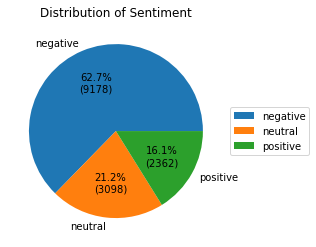

In [16]:
#visualize
LABELS = ['negative', 'neutral', 'positive']

def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots(figsize =(4, 4))
ax.pie(Uniq_vals, 
       labels=LABELS, 
       autopct=lambda pct: func(pct, Uniq_vals))

ax.legend(loc ="center left", bbox_to_anchor =(1, 0, 0.5, 1))
ax.set_title('Distribution of Sentiment')
plt.show()

In [17]:
#Tokenizer for Data
tokenizer = Tokenizer(num_words=2000, split=' ')
tokenizer.fit_on_texts(data['text'].values)

X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

In [18]:
#Build LSTM model
model = Sequential()
model.add(Embedding(2000, 128,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 128)           256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 32, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
#One-hot encoding & Train Test Split
y = pd.get_dummies(data['airline_sentiment']).values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42, shuffle=True)
# print X , y Shape 
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(9808, 32) (9808, 3)
(4832, 32) (4832, 3)


In [21]:
#Fit LSTM model
history = model.fit(X_train, y_train, epochs = 20, batch_size= 4, validation_data = (X_test, y_test), verbose = 1)

Epoch 1/20
2452/2452 [==============================] - 117s 47ms/step - loss: 0.6510 - accuracy: 0.7375 - val_loss: 0.5219 - val_accuracy: 0.7901
Epoch 2/20
2452/2452 [==============================] - 108s 44ms/step - loss: 0.4756 - accuracy: 0.8179 - val_loss: 0.5005 - val_accuracy: 0.8100
Epoch 3/20
2452/2452 [==============================] - 108s 44ms/step - loss: 0.4071 - accuracy: 0.8442 - val_loss: 0.5050 - val_accuracy: 0.8082
Epoch 4/20
2452/2452 [==============================] - 115s 47ms/step - loss: 0.3542 - accuracy: 0.8697 - val_loss: 0.5468 - val_accuracy: 0.7966
Epoch 5/20
2452/2452 [==============================] - 111s 45ms/step - loss: 0.3169 - accuracy: 0.8778 - val_loss: 0.5566 - val_accuracy: 0.7993
Epoch 6/20
2452/2452 [==============================] - 109s 44ms/step - loss: 0.2753 - accuracy: 0.8936 - val_loss: 0.6234 - val_accuracy: 0.8046
Epoch 7/20
2452/2452 [==============================] - 114s 47ms/step - loss: 0.2474 - accuracy: 0.9025 - val_loss: 0

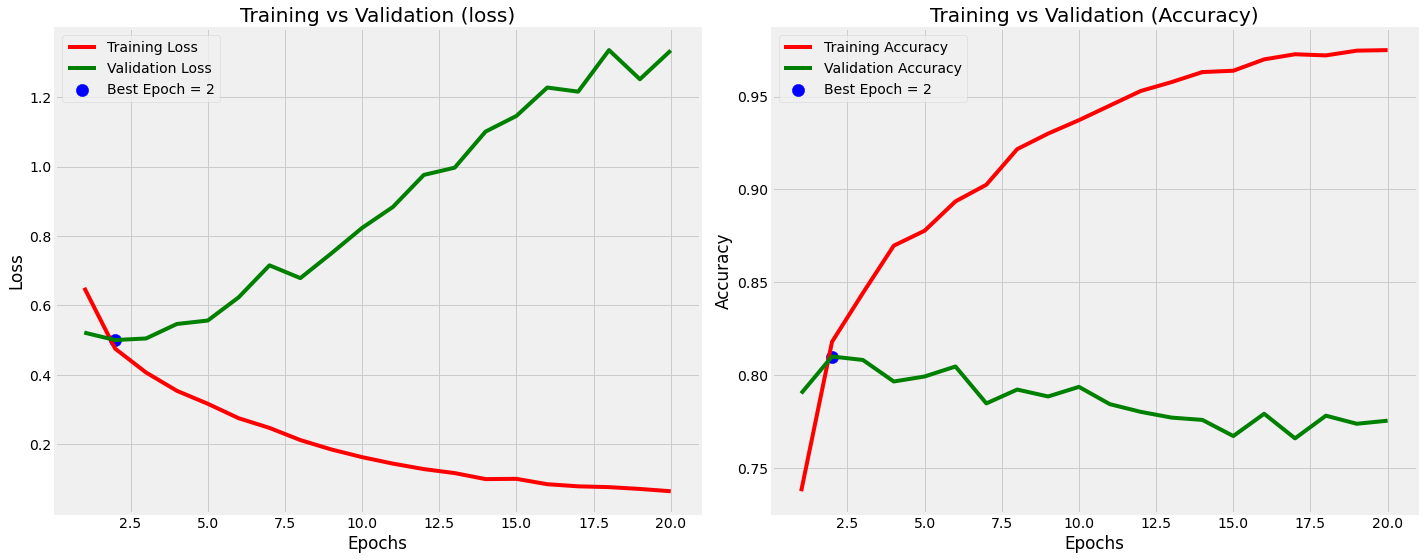

In [22]:
#show plot
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
#evalution of model
score, acc = model.evaluate(X_test, y_test, batch_size = 4, verbose=0)

print('Score: {:.2f}'.format(score))
print('Accuracy: {:.2f}'.format(acc))

Score: 1.33
Accuracy: 0.78


In [25]:
#Make prediction

# Get tweet
tweet = ['Grateful for the simple joys that make life wonderful - kindness, laughter, and the endless possibilities that lie ahead. ']

# Vectorize the tweet using our tokenizer
tweet = tokenizer.texts_to_sequences(tweet)

# Padding the tweet to have exactly the same shape as the model's input
tweet = pad_sequences(tweet, maxlen=32, dtype='int32', padding='post', truncating='post', value=0)
print(tweet)

sentiment = model.predict(tweet, batch_size=1, verbose=1)[0]
print(sentiment)

if np.argmax(sentiment) == 0:
    print("negative")
elif np.argmax(sentiment) == 1:
    print("positive")
elif np.argmax(sentiment) == 2:
    print("neutral")

[[   7    2 1536   26  126  567  895   10    2   26 1292 1285    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]
1/1 [==============================] - 0s 17ms/step
[0.44551572 0.46757522 0.08690905]
positive
